In [9]:
# 内置库
import copy
import gc
import os
import pickle
import random
import sys

# 数据处理和数学计算库
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.linalg import svd
from scipy.spatial import distance
from scipy.spatial.distance import cosine, squareform

# 机器学习库
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# PyTorch相关库
import torch
import torch.nn.functional as F
import torch.utils.data as data
from torch import nn, optim, autograd
from torch.utils.data import DataLoader, Dataset

# 数据可视化库
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots
from torchvision import datasets, transforms

# Jupyter特定功能
%matplotlib inline
from IPython.display import clear_output

torch.manual_seed(43)
np.random.seed(43)

#data_utils.py
import numpy as np
from torch.utils.data import Subset

def split_noniid(train_idcs, train_labels, alpha, n_clients):
    '''
    Splits a list of data indices with corresponding labels
    into subsets according to a dirichlet distribution with parameter
    alpha
    '''
    n_classes = train_labels.max()+1
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)

    class_idcs = [np.argwhere(train_labels[train_idcs]==y).flatten()
           for y in range(n_classes)]

    client_idcs = [[] for _ in range(n_clients)]
    for c, fracs in zip(class_idcs, label_distribution):
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1]*len(c)).astype(int))):
            client_idcs[i] += [idcs]

    client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]

    return client_idcs

class CustomSubset(Subset):
    '''A custom subset class with customizable data transformation'''
    def __init__(self, dataset, indices, subset_transform=None):
        super().__init__(dataset, indices)
        self.subset_transform = subset_transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]

        if self.subset_transform:
            x = self.subset_transform(x)

        return x, y



def find_optimal_clusters(similarity_matrix, max_clusters=10):
    """
    从相似度矩阵中找到最佳的聚类数 m，以最大化聚类间的相互距离。

    参数:
    - similarity_matrix: n x n 的相似度矩阵。
    - max_clusters: 考虑的最大聚类数，默认为 10。

    返回:
    - 最佳聚类数 m。
    """
    # 将相似度矩阵转换为距离矩阵
    distance_matrix = 1 - similarity_matrix
    
    # 确保对角线上的值为0（距离矩阵的对角线上应该为0，表示点到自身的距离）
    np.fill_diagonal(distance_matrix, 0)
    
    # 存储每个聚类数的轮廓系数
    silhouette_scores = []
    
    # 遍历从2到max_clusters的所有可能的聚类数
    for n_clusters in range(2, max_clusters + 1):
        # 进行聚类
        clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
        cluster_labels = clusterer.fit_predict(distance_matrix)
        # print(len(set(cluster_labels)))
        
        # 计算轮廓系数
        silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric="precomputed")
        silhouette_scores.append((n_clusters, silhouette_avg))
    
    # 找到轮廓系数最大的聚类数
    optimal_cluster_count = max(silhouette_scores, key=lambda x: x[1])[0]
    
    return optimal_cluster_count

import random
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.cluster import AgglomerativeClustering

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

class FederatedTrainingDevice(object):
    def __init__(self, model_fn, data):
        self.model = model_fn().to(device)
        self.data = data
        self.W = {key : value for key, value in self.model.named_parameters()}

    def evaluate(self, loader=None):
        return eval_op(self.model, self.eval_loader if not loader else loader)


class Client(FederatedTrainingDevice):
    def __init__(self, model_fn, optimizer_fn, data, idnum, batch_size=128, train_frac=0.8):
        super().__init__(model_fn, data)
        self.optimizer = optimizer_fn(self.model.parameters())

        self.data = data
        n_train = int(len(data)*train_frac)
        n_eval = len(data) - n_train
        data_train, data_eval = torch.utils.data.random_split(self.data, [n_train, n_eval])

        self.train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
        self.eval_loader = DataLoader(data_eval, batch_size=batch_size, shuffle=False)

        self.id = idnum

        self.dW = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}
        self.W_old = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}

    def synchronize_with_server(self, server):
        copy(target=self.W, source=server.W)

    def compute_weight_update(self, epochs=1, loader=None):
        copy(target=self.W_old, source=self.W)
        self.optimizer.param_groups[0]["lr"]*=0.99
        train_stats = train_op(self.model, self.train_loader if not loader else loader, self.optimizer, epochs)
        subtract_(target=self.dW, minuend=self.W, subtrahend=self.W_old)#计算梯度更新量
        return train_stats

    def reset(self):
        copy(target=self.W, source=self.W_old)

#helper类
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import sys

def mean_without_zeros(arr):
    # 创建一个布尔掩码，将0值替换为NaN，非0值保留原值
    masked_arr = np.where(arr == 0, np.nan, arr)
    # 使用nanmean计算均值，这会自动忽略NaN值
    mean_values = np.nanmean(masked_arr, axis=1)
    return mean_values

class ExperimentLogger:
    def log(self, values):
        for k, v in values.items():
            if k not in self.__dict__:
                self.__dict__[k] = [v]
            else:
                self.__dict__[k] += [v]

def highlight_max(s):
    global max_values
    is_max = s == s.max()
    max_values.append(s.max())  # 将最大值添加到列表中
    return ['background-color: yellow' if v else '' for v in is_max]

def display_train_stats(res_mean,res_std, cfl_stats, eps_1, eps_2, communication_rounds):
    clear_output(wait=True)

    # print(np.mean(cfl_stats.acc_clients, axis=1))
    # print(cfl_stats.models_acc)
    # if flag==False:
    #   acc_mean = np.mean(cfl_stats.acc_clients, axis=1)
    # else:
    #   acc_mean = np.mean(cfl_stats.models_acc, axis=1)
    acc_mean = np.mean(cfl_stats.acc_clients, axis=1)
    print(acc_mean)
    res_mean=acc_mean
    # if cfl_stats.models_acc==[[]]:
    #   acc_std = np.std(cfl_stats.acc_clients, axis=1)
    # else:
    #   acc_std = np.std(cfl_stats.models_acc, axis=1)
    acc_std = np.std(cfl_stats.acc_clients, axis=1)
    print(acc_std)

    res_std=acc_std
    plt.fill_between(cfl_stats.rounds, acc_mean-acc_std, acc_mean+acc_std, alpha=0.5, color="C0")
    plt.plot(cfl_stats.rounds, acc_mean, color="C0")

    if "split" in cfl_stats.__dict__:
       for s in cfl_stats.split:
           plt.axvline(x=s, linestyle="-", color="k", label=r"Split")

    plt.xlabel("Communication Rounds")
    plt.ylabel("Accuracy")

    plt.xlim(0, communication_rounds)
    plt.ylim(0,1)
    plt.legend()

    plt.xlim(0, communication_rounds)
    #plt.ylim(0, 2)

    plt.show()
    return res_mean,res_std

    import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

N_CLIENTS = 10  # Number of clients
DIRICHLET_ALPHA = 2  # Level of data non-uniformity, one of the hyperparameters

# # Define transforms for the dataset
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((28, 28)),  # Resize images to 28x28 (EMNIST size)
    #transforms.ToTensor()  # Convert to tensor
])
# Load data from local directory
#data = datasets.ImageFolder(root="EMNIST/by_class/", transform=transforms.ToTensor())
data = datasets.ImageFolder(root="EMNIST/by_class/",transform=transform)
# Define mapping of classes
mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

idc = np.random.permutation(len(data)) 
# train_idcss = np.random.permutation(len(data)) #随机生产697932个数字，指的是0-697931的随机排列
train_idcs, test_idcs = idc[:10000], idc[10000:20000] #切分训练数据和验证数据


# # Convert train labels to numpy array
train_labels = np.array(data.targets)

# Split non-IID data to clients
client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
# print(client_idcs)
# print(len(client_idcs))
# print(max(client_idcs[0]))
# Create subsets for each client
client_data = [CustomSubset(data, idcs, transforms.Compose([transforms.ToTensor()])) for idcs in client_idcs]

# Create test data subset
test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

#models.py
import torch
import torch.nn.functional as F
import warnings


import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 定义第一个卷积层，输入通道为1，输出通道为16，卷积核大小为5x5
        self.conv1 = nn.Conv2d(1, 16, 5)
        # 定义第一个BatchNorm层，与卷积层的输出通道数相同
        self.bn1 = nn.BatchNorm2d(16)
        # 定义池化层，窗口大小为2x2
        self.pool = nn.MaxPool2d(2, 2)
        # 定义第二个卷积层，输入通道为16，输出通道为32，卷积核大小为5x5
        self.conv2 = nn.Conv2d(16, 32, 5)
        # 定义第二个BatchNorm层，与卷积层的输出通道数相同
        self.bn2 = nn.BatchNorm2d(32)
        # 定义第一个全连接层，输入特征数为32*4*4，输出特征数为120
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        # 定义第二个全连接层，输入特征数为120，输出特征数为84
        self.fc2 = nn.Linear(120, 84)
        # 定义输出层，输入特征数为84，输出特征数为62
        self.fc3 = nn.Linear(84, 62)
        # 定义Dropout层，丢弃率为0.5
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 通过第一个卷积层，激活函数，BatchNorm层和池化层
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # 通过第二个卷积层，激活函数，BatchNorm层和池化层
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # 展平操作，准备进入全连接层
        x = x.view(-1, 32 * 4 * 4)
        # 通过第一个全连接层和激活函数
        x = F.relu(self.fc1(x))
        # 通过Dropout层和第二个全连接层，激活函数
        x = self.dropout(F.relu(self.fc2(x)))
        # 通过输出层
        x = self.fc3(x)
        return x


for i, client_datum in enumerate(client_data):  #client_data是子数据集，将子数据集按照标签及数据进行拆分
    if i<5: #如果i大于5？是什么意思（索引大于五）
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),transforms.ToTensor()])
        #意义不明，将图片进行旋转，为了识别效果更差吗，增强数据集
    else:
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])


def train_op(model, loader, optimizer, epochs=1):
    model.train()
    for ep in range(epochs):
        running_loss, samples = 0.0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            loss = torch.nn.CrossEntropyLoss()(model(x), y)
            running_loss += loss.item()*y.shape[0]
            samples += y.shape[0]

            loss.backward()
            optimizer.step()

    return running_loss / samples

def eval_op(model, loader):
    model.train()
    samples, correct = 0, 0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)

            y_ = model(x)
            _, predicted = torch.max(y_.data, 1)

            samples += y.shape[0]
            correct += (predicted == y).sum().item()
    return correct/samples

def copy(target, source):
    for name in target:
        target[name].data = source[name].data.clone()

def subtract_(target, minuend, subtrahend):
    for name in target:
        target[name].data = minuend[name].data.clone()-subtrahend[name].data.clone()

def reduce_add_average(targets, sources):
    for target in targets:
        for name in target:
            tmp = torch.mean(torch.stack([source[name].data for source in sources]), dim=0).clone()
            target[name].data += tmp

def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])

def pairwise_angles(sources):
    angles = torch.zeros([len(sources), len(sources)])
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            s1 = flatten(source1)
            s2 = flatten(source2)
            angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-12)

    return angles.numpy()

class Server(FederatedTrainingDevice):
    def __init__(self, model_fn, data):
        super().__init__(model_fn, data)
        self.loader = DataLoader(self.data, batch_size=128, shuffle=False)
        self.model_cache = []

    def select_clients(self, clients, frac=1.0):
        return random.sample(clients, int(len(clients)*frac))

    def aggregate_weight_updates(self, clients):
        reduce_add_average(target=self.W, sources=[client.dW for client in clients])

    def compute_pairwise_similarities(self, clients):
        return pairwise_angles([client.dW for client in clients])

    def cluster_clients(self, S): #聚类算法 可以修改
        clustering = AgglomerativeClustering(affinity="precomputed", linkage="complete").fit(-S)

        c1 = np.argwhere(clustering.labels_ == 0).flatten()
        c2 = np.argwhere(clustering.labels_ == 1).flatten()
        return c1, c2

    def aggregate_clusterwise(self, client_clusters):
        for cluster in client_clusters:
            reduce_add_average(targets=[client.W for client in cluster],
                               sources=[client.dW for client in cluster])

    def compute_max_update_norm(self, cluster):
        return np.max([torch.norm(flatten(client.dW)).item() for client in cluster])

    def compute_mean_update_norm(self, cluster):
        return torch.norm(torch.mean(torch.stack([flatten(client.dW) for client in cluster]),dim=0)).item()

    def cache_model(self, idcs, params, accuracies):
        self.model_cache += [(idcs,{name : params[name].data.clone() for name in params},[accuracies[i] for i in idcs])]

server = Server(ConvNet, test_data)

Client 0:


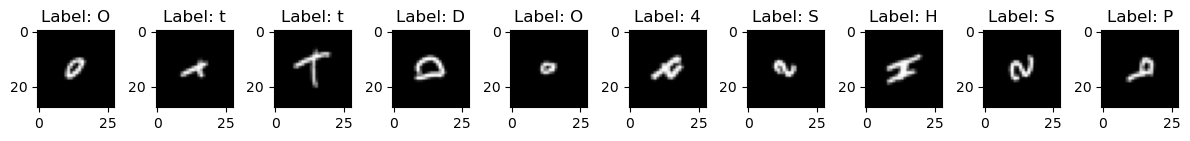

Client 1:


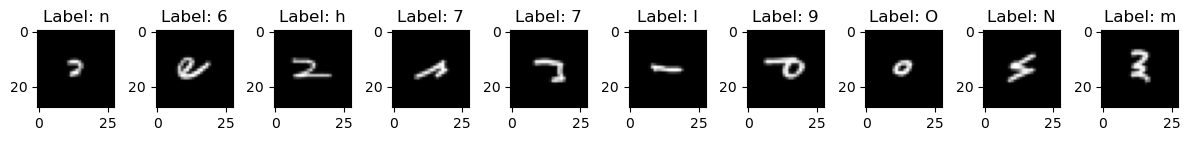

In [10]:
import numpy as np
import torchvision.utils as vutils
from copy import deepcopy

clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i)
           for i, dat in enumerate(client_data)]

for client in [clients[0], clients[1]]: #依次输出客户0和客户5的前10个图片数据
    # x, y = iter(client.train_loader).next()
    x, y = next(iter(client.train_loader))
    print("Client {}:".format(client.id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")#x[i, 0] 表示第 i 个图像的第一个通道，i为图片的索引
        plt.title("Label: {}".format(mapp[y[i].item()]))#标签
    plt.show()
server = Server(ConvNet, test_data)

g_server=deepcopy(server)
g_clients=deepcopy(clients)

In [11]:
from more_itertools import set_partitions

data_points = list(range(0, 10))

partition_counts = {}

partitions = list(set_partitions(data_points, 2))
print(partitions)

[[[0], [1, 2, 3, 4, 5, 6, 7, 8, 9]], [[0, 1], [2, 3, 4, 5, 6, 7, 8, 9]], [[1], [0, 2, 3, 4, 5, 6, 7, 8, 9]], [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9]], [[1, 2], [0, 3, 4, 5, 6, 7, 8, 9]], [[0, 2], [1, 3, 4, 5, 6, 7, 8, 9]], [[2], [0, 1, 3, 4, 5, 6, 7, 8, 9]], [[0, 1, 2, 3], [4, 5, 6, 7, 8, 9]], [[1, 2, 3], [0, 4, 5, 6, 7, 8, 9]], [[0, 2, 3], [1, 4, 5, 6, 7, 8, 9]], [[2, 3], [0, 1, 4, 5, 6, 7, 8, 9]], [[0, 1, 3], [2, 4, 5, 6, 7, 8, 9]], [[1, 3], [0, 2, 4, 5, 6, 7, 8, 9]], [[0, 3], [1, 2, 4, 5, 6, 7, 8, 9]], [[3], [0, 1, 2, 4, 5, 6, 7, 8, 9]], [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]], [[1, 2, 3, 4], [0, 5, 6, 7, 8, 9]], [[0, 2, 3, 4], [1, 5, 6, 7, 8, 9]], [[2, 3, 4], [0, 1, 5, 6, 7, 8, 9]], [[0, 1, 3, 4], [2, 5, 6, 7, 8, 9]], [[1, 3, 4], [0, 2, 5, 6, 7, 8, 9]], [[0, 3, 4], [1, 2, 5, 6, 7, 8, 9]], [[3, 4], [0, 1, 2, 5, 6, 7, 8, 9]], [[0, 1, 2, 4], [3, 5, 6, 7, 8, 9]], [[1, 2, 4], [0, 3, 5, 6, 7, 8, 9]], [[0, 2, 4], [1, 3, 5, 6, 7, 8, 9]], [[2, 4], [0, 1, 3, 5, 6, 7, 8, 9]], [[0, 1, 4], [2, 3, 5, 6, 7,

In [12]:
# 将 partitions 转换为01分组
def convert_partitions_to_binary(partitions):
    # 找到集合中的最大索引
    max_index = max(max(p[0] + p[1]) for p in partitions)
    
    # 初始化一个列表，长度等于最大索引加一，初始值为0
    binary_partitions = []

    # 遍历每个划分
    for partition in partitions:
        # 初始化当前划分的01分组列表
        binary_partition = [0] * (max_index + 1)
        
        # 遍历划分中的每个子集
        for subset_index, subset in enumerate(partition):
            # 遍历子集中的每个元素索引
            for element_index in subset:
                # 将元素的索引设置为子集的索引（0或1）
                binary_partition[element_index] = subset_index
        
        # 将当前划分的01分组添加到列表中
        binary_partitions.append(binary_partition)
    
    return binary_partitions

# 转换并打印01分组
binary_partitions = convert_partitions_to_binary(partitions)
# for binary_partition in binary_partitions:
#     print(binary_partition)

# 根据分区的长度进行排序
sorted_binary_partitions = sorted(binary_partitions, key=lambda x: len(x))
print(sorted_binary_partitions)

[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 1, 1, 1, 1, 1, 1, 1], [0, 1, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 0, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 1, 0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [1, 0, 1, 0, 1, 1, 1, 1, 1, 1], [0, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 1, 0, 0, 0, 1, 1, 1, 1, 1], [1, 1, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 1, 0, 0, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0, 1, 1, 1, 1, 1], [0, 1, 1, 0, 0, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 1, 0, 1, 1, 1, 1, 1], [1, 0, 0, 1, 0, 1, 1, 1, 1, 1], [0, 1, 0, 1, 0, 1, 1, 1, 1, 1], [1, 1, 0, 1, 0, 1, 1, 1, 1, 1], [0, 0, 1, 1, 0, 1, 1, 1, 1, 1], [1, 0, 1, 1, 0, 1, 1, 1, 1, 1], [0, 1, 1, 1, 0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 1, 1, 1, 1, 1], [0, 0, 

In [13]:
# 假设 partitions 是一个由元组组成的列表，其中每个元组代表一个划分
# 例如: partitions = [(0, 1, 2), (3, 4, 5)] 表示两个分组 {0, 1, 2} 和 {3, 4, 5}

# 将分组转换为01分组
def convert_to_binary_partition(partitions, total_elements):
    # 初始化一个列表，长度等于总元素数，初始值为0
    binary_partitions = [0] * total_elements
    
    # 遍历每个分组
    for group_index, group in enumerate(partitions):
        # 遍历分组中的每个元素
        for element in group:
            # 将元素的值设置为当前分组的索引（0或1）
            binary_partitions[element] = group_index
    
    return binary_partitions

# 示例：初始化数据点和分组
partitions = [(0, 1, 2), (3, 4, 5)]  # 示例分组

# 将分组转换为01分组
binary_partition = convert_to_binary_partition(partitions, len(list(range(10))))

# 打印转换后的01分组
print("01分组:", binary_partition)

01分组: [0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def remove_empty_lists(input_list):
    result_list = [sublist for sublist in input_list if sublist]
    return result_list


def run_federated_learning(server, clients):
    zuhe=[]
    zuhe_v=[]


    COMMUNICATION_ROUNDS = 2  #通信轮数

    cluster_indices_new = []

    cluster_indices = [np.arange(len(clients)).astype("int")] 
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次
        if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
            for client in clients:
                client.synchronize_with_server(server) #将server模型参数下发到client

        participating_clients = server.select_clients(clients, frac=1.0)



        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=1)
            client.reset()

        similarities = server.compute_pairwise_similarities(clients)
        print(similarities)

        if  (c_round%1000==0 and  c_round>=30) or c_round==1 or c_round==2:
            if c_round==1 :
                clusters_res=[[0,1,2,3,4,5,6,7,8,9]]
            if c_round==2 :
                clusters_res=[[0,1,2,3,4],[5,6,7,8,9]]
            cluster_indices_new=clusters_res
        
        if cluster_indices_new!=[]:
            cluster_indices = cluster_indices_new #集合更新
            cluster_indices = remove_empty_lists(cluster_indices)

        print(cluster_indices)

        # if c_round==2 :
        #     # W_list=[]
        #     dW_list=[]
        #     # model_list=[]
        #     # optimizer_list=[]
        #     for client in clients:
        #         # W_list.append(deepcopy(client.W))
        #         dW_list.append(deepcopy(client.dW))
        #         # model_list.append(deepcopy(client.model))
        #         # optimizer_list.append(deepcopy(client.optimizer))


        if c_round==2 :
            a=deepcopy(clients)
            print(a)

        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组
        
        server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重
        
        acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list

        print(np.mean(acc_clients))

        # if c_round==2 :
        #     b=deepcopy(clients)

        if c_round==2:
            break

            # for comb in partitions:
            #     clients=deepcopy(a)
            #     print("*")
            #     cluster_indices=comb
            #     print(cluster_indices)
            #     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组
            #     server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重
            #     acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list
            #     print(np.mean(acc_clients))
            #     zuhe.append(comb)
            #     zuhe_v.append(np.mean(acc_clients))
            #     break
    
    return a,similarities

for i in range(1):
    server=deepcopy(g_server)
    clients=deepcopy(g_clients)
    a,similarities=run_federated_learning(server,clients)


# import pickle


# lists_to_pickle = [zuhe, zuhe_v]

# with open('lists.pkl', 'wb') as file:
#     pickle.dump(lists_to_pickle, file)

[[1.         0.1826942  0.18718413 0.21222681 0.152177   0.23446485
  0.22070564 0.17188154 0.0865768  0.04238823]
 [0.1826942  0.9999999  0.54911906 0.35490537 0.30371794 0.38603175
  0.3289123  0.28736427 0.30212024 0.4771427 ]
 [0.18718413 0.54911906 1.         0.32669777 0.3655604  0.35950845
  0.44028515 0.3120651  0.43094257 0.48718002]
 [0.21222681 0.35490537 0.32669777 1.         0.26429427 0.32719654
  0.32948077 0.29346383 0.3103294  0.33556175]
 [0.152177   0.30371794 0.3655604  0.26429427 0.99999994 0.43818042
  0.3205135  0.11096681 0.33530158 0.39379972]
 [0.23446485 0.38603175 0.35950845 0.32719654 0.43818042 1.
  0.52145535 0.42560968 0.28380874 0.40085334]
 [0.22070564 0.3289123  0.44028515 0.32948077 0.3205135  0.52145535
  1.         0.48662883 0.3652106  0.47932383]
 [0.17188154 0.28736427 0.3120651  0.29346383 0.11096681 0.42560968
  0.48662883 1.0000001  0.28153735 0.3454158 ]
 [0.0865768  0.30212024 0.43094257 0.3103294  0.33530158 0.28380874
  0.3652106  0.28153

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

similarity_matrix = np.array(similarities)  # 确保相似性矩阵已经正确定义和初始化
# 尝试不同的聚类数目
best_num_clusters = 2  # 假设2为起始聚类数目
best_silhouette = -np.inf

for n_clusters in range(2, 10):  # 尝试从2到9个聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(similarity_matrix)
    
    # 计算轮廓系数
    silhouette_avg = silhouette_score(similarity_matrix, kmeans.labels_)
    
    # 记录最优的聚类数目
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_num_clusters = n_clusters
        best_labels = kmeans.labels_  # 保存当前最优的聚类标签

print(f"最优的聚类数目是: {best_num_clusters}")

# 假设data_points是包含用户标号的列表
data_points = list(range(len(similarity_matrix)))  # 这里假设用户标号是0到相似性矩阵行数-1

# 输出每个用户所属的聚类标号
clustered_data_points = {}
for user, label in zip(data_points, best_labels):
    clustered_data_points.setdefault(label, []).append(user)

print("用户所属聚类标号:")

best_clusters=[]
for cluster_id, users in clustered_data_points.items():
    print(f"聚类 {cluster_id}: 用户标号 {users}")
    best_clusters.append(users)
print(best_clusters)


最优的聚类数目是: 2
用户所属聚类标号:
聚类 0: 用户标号 [0]
聚类 1: 用户标号 [1, 2, 3, 4, 5, 6, 7, 8, 9]
[[0], [1, 2, 3, 4, 5, 6, 7, 8, 9]]


/data/test/miniconda3/envs/zhouying/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/data/test/miniconda3/envs/zhouying/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/data/test/miniconda3/envs/zhouying/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/data/test/miniconda3/envs/zhouying/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

In [16]:
import random

list_quanju=[]
list_quanju_v=[]
# 适应度函数：计算个体中1的总数

def deep_equals(list1, list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if isinstance(list1[i], list) and isinstance(list2[i], list):
            if not deep_equals(list1[i], list2[i]):
                return False
        elif list1[i] != list2[i]:
            return False
    return True

def find_combination_indices(list_of_combinations, target_combination):
    indices = []
    for index, combination in enumerate(list_of_combinations):
        if deep_equals(combination, target_combination) or deep_equals(combination, target_combination[::-1]):
            indices.append(index)
    return indices

def fitness(individual):
    print("*")
    indexes_of_ones = [index for index, value in enumerate(individual) if value == 0]
    indexes_of_zeros = [index for index, value in enumerate(individual) if value == 1]
    cluster_indices=[indexes_of_ones,indexes_of_zeros]
    cluster_indices1=[indexes_of_zeros,indexes_of_ones]
    index=find_combination_indices(list_quanju,cluster_indices)
    index1=find_combination_indices(list_quanju,cluster_indices1)
    
    if index!=[] or index1!=[]:
        if index!=None:
            # print(index)
            return list_quanju_v[index[0]]
        if index1!=None:
            return list_quanju_v[index1[0]]
    if [] in cluster_indices:
        return 0
    print(cluster_indices)
    clients=deepcopy(a)
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
    server.aggregate_clusterwise(client_clusters)
    acc_clients = [client.evaluate() for client in clients]
    list_quanju.append(cluster_indices)
    list_quanju_v.append(np.mean(acc_clients))
    return np.mean(acc_clients)

import random

def selection_e(population, fitnesses, elite_count=3):
    # 精英策略：直接选择精英个体
    # 根据适应度对个体和适应度进行排序
    sorted_population_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    
    # 选择适应度最高的 elite_count 个精英个体
    elite_individuals = sorted_population_fitness[:elite_count]
    
    # 返回精英个体列表
    return [individual for individual, _ in elite_individuals]

def check_last_five(max_fitness_list):
    # 检查列表长度是否至少为5，如果不是，则无法比较后五个元素
    if len(max_fitness_list) < 7:
        return False
    
    # 获取列表的最后五个元素
    last_five = max_fitness_list[-7:]
    
    # 检查最后五个元素是否全部相同
    if all(x == last_five[0] for x in last_five):
        return True
    else:
        return False
    
def selection(population, fitnesses, elite_count=10):
    # 精英策略：直接选择精英个体
    # 根据适应度对个体和适应度进行排序
    sorted_population_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    
    # 选择适应度最高的 elite_count 个精英个体
    elite_individuals = sorted_population_fitness[:elite_count]
    
    # 返回精英个体列表
    return random.choice(elite_individuals)[0]

# 交叉（杂交）函数
def crossover(ind1, ind2):
    size = len(ind1)
    crossover_point = random.randint(1, size - 1)
    child1 = ind1[:crossover_point] + ind2[crossover_point:]
    child2 = ind2[:crossover_point] + ind1[crossover_point:]
    return child1, child2

# 变异函数
def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual

# 初始化种群
# def init_population(pop_size, gene_size):
#     return [[random.randint(0, 1) for _ in range(gene_size)] for _ in range(pop_size*4)]

# sorted_binary_partitions

def init_population(pop_size,gene_size):
    pop_size=pop_size*2
    sampled_individuals = []
    
    while len(sampled_individuals) < pop_size:
        sampled_individuals.append(random.choice(sorted_binary_partitions))
    
    return sampled_individuals

# 遗传算法主函数
def genetic_algorithm(gene_size, pop_size, generations, mutation_rate):
    max_fitness_list=[]
    population = init_population(pop_size, gene_size)

    for generation in range(generations):
        # 计算适应度
        
        fitnesses = [fitness(individual) for individual in population]

        # 选择和生成新的种群
        new_population = []
        for _ in range((pop_size-4) // 2):
            # 选择两个个体进行交叉
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            child1, child2 = crossover(parent1, parent2)

            # 变异
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)

            new_population.extend([child1, child2])

        # 替换旧种群
        new_population.extend(selection_e(population,fitnesses))
        population = new_population

        # 打印当前最佳适应度
        max_fitness = max(fitnesses)
        print(f"Generation {generation}: Max Fitness = {max_fitness}")
        max_fitness_list.append(max_fitness)
        if check_last_five(max_fitness_list) :
            # and generation>=int(0.1*generations)
            break

    return max(population, key=fitness)
# 参数设置
gene_size = 10  # 基因长度
pop_size = 20   # 种群大小
generations = 30  # 迭代次数
mutation_rate = 0.01  # 变异率


best_individual_list=[]
F_best_individual_list=[]
for i in range(1):
    best_individual = genetic_algorithm(gene_size, pop_size, generations, mutation_rate)
    best_individual_list.append(best_individual)
    print(f"Best Individual: {best_individual}, Fitness: {fitness(best_individual)}")
    F_best_individual_list.append(fitness(best_individual))

fenzu_PIFCA=best_individual_list[F_best_individual_list.index(max(F_best_individual_list))]
print(fenzu_PIFCA)

*
[[1, 3, 4, 5, 8], [0, 2, 6, 7, 9]]
*
[[1, 2, 4, 6, 8], [0, 3, 5, 7, 9]]
*
[[0, 1, 5, 8], [2, 3, 4, 6, 7, 9]]
*
[[0, 3, 4, 8], [1, 2, 5, 6, 7, 9]]
*
[[0, 2, 4, 7, 8], [1, 3, 5, 6, 9]]
*
[[0, 2, 3, 4, 7], [1, 5, 6, 8, 9]]
*
[[7], [0, 1, 2, 3, 4, 5, 6, 8, 9]]
*
[[0, 3, 6], [1, 2, 4, 5, 7, 8, 9]]
*
[[0, 2, 4, 6, 7, 8], [1, 3, 5, 9]]
*
[[0, 2, 3, 4, 5, 6, 7], [1, 8, 9]]
*
[[0, 1, 2, 4, 5, 6, 7, 8], [3, 9]]
*
[[0, 3, 7], [1, 2, 4, 5, 6, 8, 9]]
*
[[1, 2, 4, 5, 7], [0, 3, 6, 8, 9]]
*
[[1, 2, 8], [0, 3, 4, 5, 6, 7, 9]]
*
[[2, 6, 8], [0, 1, 3, 4, 5, 7, 9]]
*
[[4, 5, 6, 7], [0, 1, 2, 3, 8, 9]]
*
[[0, 2, 7, 8], [1, 3, 4, 5, 6, 9]]
*
[[0, 1, 6, 7, 8], [2, 3, 4, 5, 9]]
*
[[0], [1, 2, 3, 4, 5, 6, 7, 8, 9]]
*
[[5, 6, 8], [0, 1, 2, 3, 4, 7, 9]]
*
[[0, 1, 2, 5, 6, 8], [3, 4, 7, 9]]
*
[[1, 4], [0, 2, 3, 5, 6, 7, 8, 9]]
*
[[0, 3, 5, 6, 8], [1, 2, 4, 7, 9]]
*
[[3, 4, 5, 8], [0, 1, 2, 6, 7, 9]]
*
[[1, 4, 6, 7, 8], [0, 2, 3, 5, 9]]
*
[[2, 3, 4, 5, 6, 7, 8], [0, 1, 9]]
*
[[2, 4, 5, 6, 7], [0, 1, 3, 8, 9]]
*

In [17]:
import random


# fenzu_PIFCA=[1, 1, 0, 0, 0, 1, 1, 1, 1, 1]

def deep_equals(list1, list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if isinstance(list1[i], list) and isinstance(list2[i], list):
            if not deep_equals(list1[i], list2[i]):
                return False
        elif list1[i] != list2[i]:
            return False
    return True

def find_combination_indices(list_of_combinations, target_combination):
    indices = []
    for index, combination in enumerate(list_of_combinations):
        if deep_equals(combination, target_combination) or deep_equals(combination, target_combination[::-1]):
            indices.append(index)
    return indices


def f(individual):
    print("*")
    indexes_of_ones = [index for index, value in enumerate(individual) if value == 0]
    indexes_of_zeros = [index for index, value in enumerate(individual) if value == 1]
    cluster_indices=[indexes_of_ones,indexes_of_zeros]
    cluster_indices1=[indexes_of_zeros,indexes_of_ones]
    index=find_combination_indices(list_quanju,cluster_indices)
    index1=find_combination_indices(list_quanju,cluster_indices1)
    
    if index!=[] or index1!=[]:
        if index!=None:
            # print(index)
            return list_quanju_v[index[0]]
        if index1!=None:
            return list_quanju_v[index1[0]]
    if [] in cluster_indices:
        return 0
    print(cluster_indices)
    clients=deepcopy(a)
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
    server.aggregate_clusterwise(client_clusters)
    acc_clients = [client.evaluate() for client in clients]
    list_quanju.append(cluster_indices)
    list_quanju_v.append(np.mean(acc_clients))
    return np.mean(acc_clients)

def fitness(individual,cu,cu_bu):
    chars_list=cu
    print("*")
    indexes_of_zeros = [char for idx, char in enumerate(chars_list) if individual[idx] == 0]
    indexes_of_ones = [char for idx, char in enumerate(chars_list) if individual[idx] == 1]
    cluster_indices=[indexes_of_ones,indexes_of_zeros]
    cluster_indices1=[indexes_of_zeros,indexes_of_ones]
    index=find_combination_indices(list_quanju,cluster_indices)
    # print(index)
    index1=find_combination_indices(list_quanju,cluster_indices1)
    # print(index1)
    if [] in cluster_indices:
        return 0
    if index!=[] or index1!=[]:
        if index!=None:
            return list_quanju_v[index[0]]
        if index1!=None:
            return list_quanju_v[index1[0]]
    print(cluster_indices)
    list_quanju.append([indexes_of_ones,indexes_of_zeros])
    print(len(list_quanju))
    cluster_indices.extend(cu_bu)
    clients=deepcopy(a)
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
    server.aggregate_clusterwise(client_clusters)
    acc_clients = [client.evaluate() for client in clients]
    list_quanju_v.append(np.mean(acc_clients))
    return np.mean(acc_clients)

import random

def selection_e(population, fitnesses, elite_count=3):
    # 精英策略：直接选择精英个体
    # 根据适应度对个体和适应度进行排序
    sorted_population_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    
    # 选择适应度最高的 elite_count 个精英个体
    elite_individuals = sorted_population_fitness[:elite_count]
    
    # 返回精英个体列表
    return [individual for individual, _ in elite_individuals]

def check_last_five(max_fitness_list):
    # 检查列表长度是否至少为5，如果不是，则无法比较后五个元素
    if len(max_fitness_list) < 7:
        return False
    
    # 获取列表的最后五个元素
    last_five = max_fitness_list[-7:]
    
    # 检查最后五个元素是否全部相同
    if all(x == last_five[0] for x in last_five):
        return True
    else:
        return False
    
def selection(population, fitnesses, elite_count=10):
    # 精英策略：直接选择精英个体
    # 根据适应度对个体和适应度进行排序
    sorted_population_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    
    # 选择适应度最高的 elite_count 个精英个体
    elite_individuals = sorted_population_fitness[:elite_count]
    
    # 返回精英个体列表
    return random.choice(elite_individuals)[0]

# 交叉（杂交）函数
def crossover(ind1, ind2):
    size = len(ind1)
    if size<1:
        print("+++")
        print(ind1)
        print(ind2)
    crossover_point = random.randint(1, size - 1)
    child1 = ind1[:crossover_point] + ind2[crossover_point:]
    child2 = ind2[:crossover_point] + ind1[crossover_point:]
    return child1, child2

# 变异函数
def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual

# 初始化种群
def init_population(pop_size, gene_size):
    return [[random.randint(0, 1) for _ in range(gene_size)] for _ in range(pop_size*4)]

# sorted_binary_partitions

# def init_population(pop_size,gene_size):
#     pop_size=pop_size*2
#     sampled_individuals = []
    
#     while len(sampled_individuals) < pop_size:
#         sampled_individuals.append(random.choice(sorted_binary_partitions))
    
#     return sampled_individuals

# 遗传算法主函数
def genetic_algorithm(gene_size, pop_size, generations, mutation_rate,cu,cu_bu):
    max_fitness_list=[]
    population = init_population(pop_size, gene_size)

    for generation in range(generations):
        # 计算适应度
        
        fitnesses = [fitness(individual,cu,cu_bu) for individual in population]

        # 选择和生成新的种群
        new_population = []
        for _ in range((pop_size-3) // 2):
            # 选择两个个体进行交叉
            
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            # print(population)
            child1, child2 = crossover(parent1, parent2)

            # 变异
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)

            new_population.extend([child1, child2])

        # 替换旧种群
        new_population.extend(selection_e(population,fitnesses))
        population = new_population

        # 打印当前最佳适应度
        max_fitness = max(fitnesses)
        print(f"Generation {generation}: Max Fitness = {max_fitness}")
        max_fitness_list.append(max_fitness)
        if check_last_five(max_fitness_list) :
            # and generation>=int(0.1*generations)
            break

    return max(population, key=lambda individual: fitness(individual, cu, cu_bu))


tmp_1=[]
while tmp_1!=fenzu_PIFCA:
    indexes_of_ones = [index for index, value in enumerate(fenzu_PIFCA) if value == 0]
    indexes_of_zeros = [index for index, value in enumerate(fenzu_PIFCA) if value == 1]
    cluster_indices=[indexes_of_ones,indexes_of_zeros]
    tmp_1=cluster_indices
    cu_base=cluster_indices
    zuihao_list=[]
    zuihao_list.append(cu_base)
    for cu in range(len(cu_base)):
        list_quanju=[]
        list_quanju_v=[]
        gene_size = len(cu_base[cu])  # 基因长度
        print(gene_size)
        pop_size = 20   # 种群大小
        generations = 30  # 迭代次数
        mutation_rate = 0.01  # 变异率
        cu_bu = [sub_list for j, sub_list in enumerate(cu_base) if j != cu]
        best_individual_list=[]
        F_best_individual_list=[]
        for i in range(1):
            best_individual = genetic_algorithm(gene_size, pop_size, generations, mutation_rate,cu_base[cu],cu_bu)
            best_individual_list.append(best_individual)
            print(f"Best Individual: {best_individual}, Fitness: {fitness(best_individual,cu_base[cu],cu_bu)}")
            F_best_individual_list.append(fitness(best_individual,cu_base[cu],cu_bu))
        fenzu_PIFCA=best_individual_list[F_best_individual_list.index(max(F_best_individual_list))]
        print(fenzu_PIFCA)
        indexes_of_zeros = [char for idx, char in enumerate(cu_base[cu]) if fenzu_PIFCA[idx] == 0]
        indexes_of_ones = [char for idx, char in enumerate(cu_base[cu]) if fenzu_PIFCA[idx] == 1]
        tmp=[indexes_of_zeros,indexes_of_ones]
        tmp.extend(cu_bu)
        zuihao_list.append(tmp)
    print(max(zuihao_list, key=lambda individual: f(individual)))
    fenzu_PIFCA=max(zuihao_list, key=lambda individual: f(individual))
    best_clusters=fenzu_PIFCA
    print("tmp:",tmp_1,"fenzu_PIFCA",fenzu_PIFCA)

    # while n<best_num_clusters:
    #     indexes_of_ones = [index for index, value in enumerate(fenzu_PIFCA) if value == 0]
    #     indexes_of_zeros = [index for index, value in enumerate(fenzu_PIFCA) if value == 1]
    #     cluster_indices=[indexes_of_ones,indexes_of_zeros]
    #     cu_base=cluster_indices
    #     zuihao_list=[]
    #     zuihao_list.append(cu_base)
    #     for cu in range(len(cu_base)):
    #         list_quanju=[]
    #         list_quanju_v=[]
    #         gene_size = len(cu_base[cu])  # 基因长度
    #         print(gene_size)
    #         pop_size = 20   # 种群大小
    #         generations = 30  # 迭代次数
    #         mutation_rate = 0.01  # 变异率
    #         cu_bu = [sub_list for j, sub_list in enumerate(cu_base) if j != cu]
    #         best_individual_list=[]
    #         F_best_individual_list=[]
    #         for i in range(1):
    #             best_individual = genetic_algorithm(gene_size, pop_size, generations, mutation_rate,cu_base[cu],cu_bu)
    #             best_individual_list.append(best_individual)
    #             print(f"Best Individual: {best_individual}, Fitness: {fitness(best_individual,cu_base[cu],cu_bu)}")
    #             F_best_individual_list.append(fitness(best_individual,cu_base[cu],cu_bu))
    #         fenzu_PIFCA=best_individual_list[F_best_individual_list.index(max(F_best_individual_list))]
    #         print(fenzu_PIFCA)
    #         indexes_of_zeros = [char for idx, char in enumerate(cu_base[cu]) if fenzu_PIFCA[idx] == 0]
    #         indexes_of_ones = [char for idx, char in enumerate(cu_base[cu]) if fenzu_PIFCA[idx] == 1]
    #         tmp=[indexes_of_zeros,indexes_of_ones]
    #         tmp.extend(cu_bu)
    #         zuihao_list.append(tmp)
    #     print(max(zuihao_list, key=lambda individual: f(individual)))
    #     fenzu_PIFCA=max(zuihao_list, key=lambda individual: f(individual))
    #     best_clusters=fenzu_PIFCA
    #     n=n+1

5
*
[[1, 2], [0, 3, 4]]
1
*
[[0], [1, 2, 3, 4]]
2
*
[[0, 1, 4], [2, 3]]
3
*
[[0, 2, 4], [1, 3]]
4
*
[[1, 2, 3], [0, 4]]
5


*
*
[[2], [0, 1, 3, 4]]
6
*
[[0, 2], [1, 3, 4]]
7
*
*
[[2, 4], [0, 1, 3]]
8
*
[[0, 2, 3, 4], [1]]
9
*
*
[[0, 1], [2, 3, 4]]
10
*
*
*
*
*
*
*
*
*
*
[[1, 2, 4], [0, 3]]
11
*
*
*
*
[[0, 1, 2], [3, 4]]
12
*
*
*
*
*
*
*
*
*
*
*
*
*
*
[[4], [0, 1, 2, 3]]
13
*
*
*
*
[[0, 2, 3], [1, 4]]
14
*
*
*
*
[[0, 1, 2, 4], [3]]
15
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
Generation 0: Max Fitness = 0.15814201270755207
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
Generation 1: Max Fitness = 0.15814201270755207
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
Generation 2: Max Fitness = 0.15814201270755207
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
Generation 3: Max Fitness = 0.15814201270755207
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
Generation 4: Max Fitness = 0.15814201270755207
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
Generation 5: Max Fitness = 0.15814201270755207
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
Generation 6: Max Fitness = 0.15814201270755207
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
Best Individual: [1,

[0.06658963 0.11625443 0.19575829 0.25656213 0.32759794 0.42498755
 0.41568047 0.50723722 0.52702083 0.5716402  0.59015036 0.60859009
 0.62336106 0.62600432 0.63761296 0.63871779 0.63750082 0.67418869
 0.66917319 0.65985952 0.69480176 0.69026515 0.69610009 0.70751935
 0.70203648 0.71873834 0.7226275  0.71750798 0.7167467  0.71316534
 0.71526937 0.72389218 0.73360595 0.73398481 0.72567776 0.73853102
 0.72170318 0.74682623 0.74156724 0.7401377  0.73467868 0.73651057
 0.73172373 0.73572617 0.75056279 0.7448698  0.74883929 0.74245543
 0.74930203 0.750698   0.74908365 0.76568209 0.7491098  0.73460547
 0.75209078 0.74467205 0.75172886 0.74589521 0.75533153 0.74863204
 0.760431   0.75527592 0.75690183 0.76637565 0.75390486 0.75952502
 0.77547521 0.75396296 0.74222792 0.74174554 0.73479921 0.756699
 0.75975254 0.75274339 0.74755721 0.75553698 0.75062772 0.75779251
 0.75541145 0.76329055 0.76256801 0.76187093 0.7510313  0.75706726
 0.75653996 0.7492261  0.75792694 0.7583074  0.75775844 0.758730

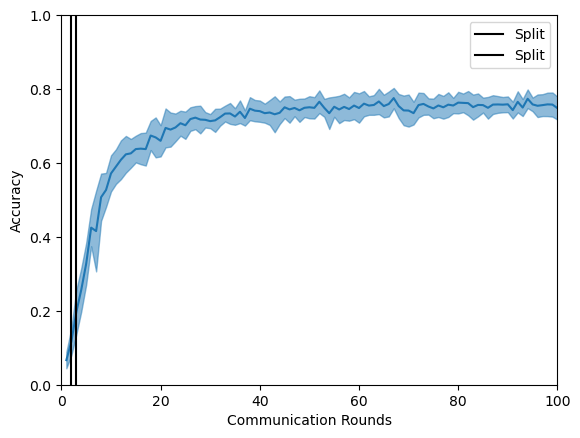

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


def run_federated_learning(server, clients,partitions):
    print(partitions)
    res_11=[]
    res_12=[]
    plt1=plt.figure(figsize=(12,4))
    plt.subplot(1,1,1)

    COMMUNICATION_ROUNDS = 100   #通信轮数
    EPS_1 = 0.4 #判断全局FL趋于稳定的条件
    EPS_2 = 1.6 #判断客户本地模型不适用的条件
    cfl_stats = ExperimentLogger() #创建实验日志
    cluster_indices_new = []
    c_flag=False
    c_flag_count=2
    models_acc=[]


    cluster_indices = [np.arange(len(clients)).astype("int")] #生成一个从0到99的整数数组，表示客户端的索引
# print(cluster_indices)
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#根据cluster_indices中更新的索引分类进行类别的划分，并进行重新编号？

    def remove_empty_lists(input_list):
    # 使用列表推导式过滤空列表
        result_list = [sublist for sublist in input_list if sublist]
        return result_list

    for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次
        if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
            for client in clients:
                client.synchronize_with_server(server) #将server模型参数下发到client

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=1)
            client.reset()

        similarities = server.compute_pairwise_similarities(clients)

        if  (c_round%1000==0 and  c_round>=30) or c_round==2 or c_round==3:
            if 0==1:
                print("eee")
            else:
                for idc in cluster_indices:
                    server.cache_model(idc, clients[idc[0]].W, acc_clients)
                if c_round==2 :
                    clusters_res=[[0,1,2,3,4,5,6,7,8,9]]
                else:
                    clusters_res=partitions #70

            cluster_indices_new=clusters_res
            cfl_stats.log({"split" : c_round})
            results = np.zeros([N_CLIENTS, len(server.model_cache)]) 
            for i, (idcs, W, accs) in enumerate(server.model_cache):
                results[idcs, i] = np.array(accs)
            frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) for i in range(results.shape[1]-1)],index = ["Client {}".format(i) for i in range(results.shape[0])])
            models_acc = frame.max(axis=1)
            c_flag_count=c_flag_count-1
            if c_flag_count==0:
                c_flag=True
        
        if cluster_indices_new!=[]:
            cluster_indices = cluster_indices_new #集合更新
            cluster_indices = remove_empty_lists(cluster_indices)

        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组

        server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重

        acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list

        print("acc",acc_clients)

        if c_flag==False:
            cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})
        else:
            max_values = [max(val1, val2) for val1, val2 in zip(models_acc, acc_clients)]
            cfl_stats.log({"acc_clients" : max_values, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})

        res_11,res_12=display_train_stats(res_11,res_12, cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS) #helper类里有画图的类意思就是把数据传进去画图
    
    return max_values,res_11,res_12

for i in range(1):
    # print(i)
    # if best_num_clusters==2:
    #     indexes_of_ones = [index for index, value in enumerate(fenzu_PIFCA) if value == 0]
    #     indexes_of_zeros = [index for index, value in enumerate(fenzu_PIFCA) if value == 1]
    #     cluster_indices=[indexes_of_ones,indexes_of_zeros]
    # else:
    cluster_indices=fenzu_PIFCA
    print(cluster_indices)
    server=deepcopy(g_server)
    clients=deepcopy(g_clients)
    tmp_max_values,res_11,res_12=run_federated_learning(server,clients,cluster_indices)


In [19]:
# #tidu xiangsidu
# import numpy as np
# import pandas as pd
# from matplotlib import pyplot as plt


# def run_federated_learning(server, clients,partitions):
#     print(partitions)
#     res_21=[]
#     res_22=[]
#     plt1=plt.figure(figsize=(12,4))
#     plt.subplot(1,1,1)

#     COMMUNICATION_ROUNDS = 100   #通信轮数
#     EPS_1 = 0.4 #判断全局FL趋于稳定的条件
#     EPS_2 = 1.6 #判断客户本地模型不适用的条件
#     cfl_stats = ExperimentLogger() #创建实验日志
#     cluster_indices_new = []
#     c_flag=False
#     c_flag_count=2
#     models_acc=[]


#     cluster_indices = [np.arange(len(clients)).astype("int")] #生成一个从0到99的整数数组，表示客户端的索引
# # print(cluster_indices)
#     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
# #根据cluster_indices中更新的索引分类进行类别的划分，并进行重新编号？

#     def remove_empty_lists(input_list):
#     # 使用列表推导式过滤空列表
#         result_list = [sublist for sublist in input_list if sublist]
#         return result_list

#     for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次
#         if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
#             for client in clients:
#                 client.synchronize_with_server(server) #将server模型参数下发到client

#         participating_clients = server.select_clients(clients, frac=1.0)

#         for client in participating_clients:
#             train_stats = client.compute_weight_update(epochs=1)
#             client.reset()

#         similarities = server.compute_pairwise_similarities(clients)

#         if  (c_round%1000==0 and  c_round>=30) or c_round==2 or c_round==3:
#             if 0==1:
#                 print("eee")
#             else:
#                 for idc in cluster_indices:
#                     server.cache_model(idc, clients[idc[0]].W, acc_clients)
#                 if c_round==2 :
#                     clusters_res=[[0,1,2,3,4,5,6,7,8,9]]
#                 else:
#                     clusters_res=partitions #70

#             cluster_indices_new=clusters_res
#             cfl_stats.log({"split" : c_round})
#             results = np.zeros([N_CLIENTS, len(server.model_cache)]) 
#             for i, (idcs, W, accs) in enumerate(server.model_cache):
#                 results[idcs, i] = np.array(accs)
#             frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) for i in range(results.shape[1]-1)],index = ["Client {}".format(i) for i in range(results.shape[0])])
#             models_acc = frame.max(axis=1)
#             c_flag_count=c_flag_count-1
#             if c_flag_count==0:
#                 c_flag=True
        
#         if cluster_indices_new!=[]:
#             cluster_indices = cluster_indices_new #集合更新
#             cluster_indices = remove_empty_lists(cluster_indices)

#         client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组

#         server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重

#         acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list

#         print("acc",acc_clients)

#         if c_flag==False:
#             cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})
#         else:
#             max_values = [max(val1, val2) for val1, val2 in zip(models_acc, acc_clients)]
#             cfl_stats.log({"acc_clients" : max_values, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})

#         res_21,res_22=display_train_stats(res_21,res_22, cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS) #helper类里有画图的类意思就是把数据传进去画图
    
#     return max_values,res_21,res_22

# for i in range(1):
#     print(i)
#     print(best_clusters)
#     server=deepcopy(g_server)
#     clients=deepcopy(g_clients)
#     tmp_max_values,res_21,res_22=run_federated_learning(server,clients,best_clusters)

[0.06007552 0.09576258 0.14752826 0.18191131 0.2584149  0.32128708
 0.35060662 0.39502986 0.42319619 0.45999203 0.47379188 0.51279
 0.51690782 0.54036606 0.55084965 0.56058561 0.55320442 0.57457882
 0.57563941 0.59063744 0.58307672 0.58356512 0.61136123 0.59198399
 0.59834506 0.59367767 0.6091223  0.62051028 0.61677731 0.60263496
 0.6310374  0.63461733 0.6115067  0.62837635 0.6418081  0.63012043
 0.63187497 0.65589393 0.64979289 0.62741574 0.64036344 0.60898833
 0.62238017 0.62475929 0.65830279 0.64879048 0.66440373 0.67640208
 0.65456703 0.65494792 0.66314576 0.66340895 0.66093396 0.65693351
 0.6479177  0.65402856 0.66090768 0.66810878 0.6687356  0.66014081
 0.65792265 0.66838631 0.67369832 0.68038127 0.68272902 0.66199507
 0.67196307 0.67645427 0.66909987 0.67517342 0.67244203 0.66679479
 0.67309129 0.66551945 0.67676315 0.67281412 0.67275945 0.67786288
 0.68079852 0.67982575 0.68824606 0.6757729  0.68501976 0.68151845
 0.67349256 0.6756956  0.68656318 0.67935154 0.66746881 0.6840175

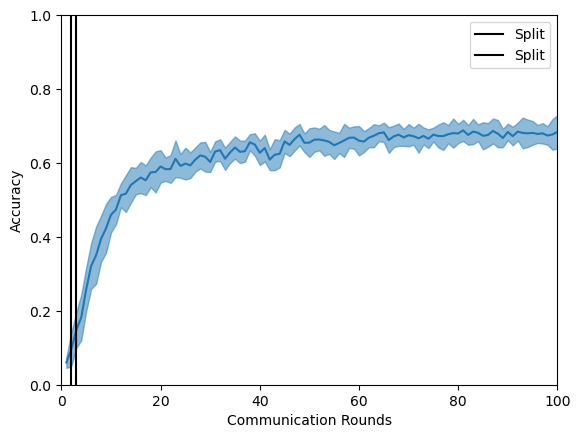

In [20]:
#fedavg
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


def run_federated_learning(server, clients,partitions):
    print(partitions)
    res_21=[]
    res_22=[]
    plt1=plt.figure(figsize=(12,4))
    plt.subplot(1,1,1)

    COMMUNICATION_ROUNDS = 100   #通信轮数
    EPS_1 = 0.4 #判断全局FL趋于稳定的条件
    EPS_2 = 1.6 #判断客户本地模型不适用的条件
    cfl_stats = ExperimentLogger() #创建实验日志
    cluster_indices_new = []
    c_flag=False
    c_flag_count=2
    models_acc=[]


    cluster_indices = [np.arange(len(clients)).astype("int")] #生成一个从0到99的整数数组，表示客户端的索引
# print(cluster_indices)
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#根据cluster_indices中更新的索引分类进行类别的划分，并进行重新编号？

    def remove_empty_lists(input_list):
    # 使用列表推导式过滤空列表
        result_list = [sublist for sublist in input_list if sublist]
        return result_list

    for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次
        if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
            for client in clients:
                client.synchronize_with_server(server) #将server模型参数下发到client

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=1)
            client.reset()

        similarities = server.compute_pairwise_similarities(clients)

        if  (c_round%1000==0 and  c_round>=30) or c_round==2 or c_round==3:
            if 0==1:
                print("eee")
            else:
                for idc in cluster_indices:
                    server.cache_model(idc, clients[idc[0]].W, acc_clients)
                if c_round==2 :
                    clusters_res=[[0,1,2,3,4,5,6,7,8,9]]
                else:
                    clusters_res=partitions #70

            cluster_indices_new=clusters_res
            cfl_stats.log({"split" : c_round})
            results = np.zeros([N_CLIENTS, len(server.model_cache)]) 
            for i, (idcs, W, accs) in enumerate(server.model_cache):
                results[idcs, i] = np.array(accs)
            frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) for i in range(results.shape[1]-1)],index = ["Client {}".format(i) for i in range(results.shape[0])])
            models_acc = frame.max(axis=1)
            c_flag_count=c_flag_count-1
            if c_flag_count==0:
                c_flag=True
        
        if cluster_indices_new!=[]:
            cluster_indices = cluster_indices_new #集合更新
            cluster_indices = remove_empty_lists(cluster_indices)

        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组

        server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重

        acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list

        print("acc",acc_clients)

        if c_flag==False:
            cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})
        else:
            max_values = [max(val1, val2) for val1, val2 in zip(models_acc, acc_clients)]
            cfl_stats.log({"acc_clients" : max_values, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})

        res_21,res_22=display_train_stats(res_21,res_22, cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS) #helper类里有画图的类意思就是把数据传进去画图
    
    return max_values,res_21,res_22

for i in range(1):
    print(i)
    print(cluster_indices)
    server=deepcopy(g_server)
    clients=deepcopy(g_clients)
    tmp_max_values,res_21,res_22=run_federated_learning(server,clients,[[0,1,2,3,4,5,6,7,8,9]])

[0.0706128  0.11601757 0.19088474 0.25988553 0.33660042 0.34577096
 0.39433168 0.43730231 0.45480879 0.46899262 0.49016586 0.50314735
 0.51432223 0.50998542 0.53330414 0.54996899 0.54098805 0.55777956
 0.55861344 0.56200904 0.56946118 0.55661689 0.58517701 0.57006785
 0.59249572 0.59105758 0.59245373 0.60334422 0.59801924 0.61510293
 0.59272129 0.59381646 0.60414062 0.59503455 0.61804776 0.61270291
 0.61458413 0.61421899 0.60997648 0.61964745 0.62580412 0.62288741
 0.60998816 0.62989208 0.63858817 0.62113025 0.63373806 0.6287753
 0.62717839 0.63348564 0.6360857  0.62017823 0.63777356 0.62980835
 0.62342344 0.62300843 0.63941783 0.63161471 0.64600282 0.65020793
 0.63290551 0.64211302 0.64455767 0.63776083 0.64823698 0.64286803
 0.65049298 0.63777554 0.64175168 0.64138915 0.64466141 0.64238011
 0.65221832 0.65481121 0.6417682  0.64082609 0.65149452 0.63788696
 0.6286984  0.64458568 0.64981973 0.64936844 0.63751128 0.64508427
 0.65983077 0.64813877 0.64621808 0.65151119 0.65384343 0.62171

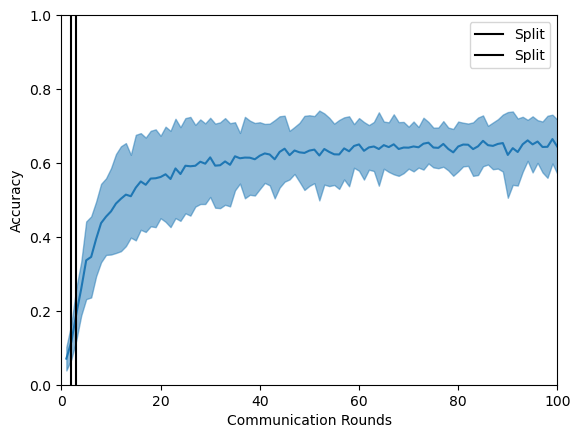

In [21]:
#solo
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


def run_federated_learning(server, clients,partitions):
    print(partitions)
    res_31=[]
    res_32=[]
    plt1=plt.figure(figsize=(12,4))
    plt.subplot(1,1,1)

    COMMUNICATION_ROUNDS = 100   #通信轮数
    EPS_1 = 0.4 #判断全局FL趋于稳定的条件
    EPS_2 = 1.6 #判断客户本地模型不适用的条件
    cfl_stats = ExperimentLogger() #创建实验日志
    cluster_indices_new = []
    c_flag=False
    c_flag_count=2
    models_acc=[]


    cluster_indices = [np.arange(len(clients)).astype("int")] #生成一个从0到99的整数数组，表示客户端的索引
# print(cluster_indices)
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#根据cluster_indices中更新的索引分类进行类别的划分，并进行重新编号？

    def remove_empty_lists(input_list):
    # 使用列表推导式过滤空列表
        result_list = [sublist for sublist in input_list if sublist]
        return result_list

    for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次
        if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
            for client in clients:
                client.synchronize_with_server(server) #将server模型参数下发到client

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=1)
            client.reset()

        similarities = server.compute_pairwise_similarities(clients)

        if  (c_round%1000==0 and  c_round>=30) or c_round==2 or c_round==3:
            if 0==1:
                print("eee")
            else:
                for idc in cluster_indices:
                    server.cache_model(idc, clients[idc[0]].W, acc_clients)
                if c_round==2 :
                    clusters_res=[[0,1,2,3,4,5,6,7,8,9]]
                else:
                    clusters_res=partitions #70

            cluster_indices_new=clusters_res
            cfl_stats.log({"split" : c_round})
            results = np.zeros([N_CLIENTS, len(server.model_cache)]) 
            for i, (idcs, W, accs) in enumerate(server.model_cache):
                results[idcs, i] = np.array(accs)
            frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) for i in range(results.shape[1]-1)],index = ["Client {}".format(i) for i in range(results.shape[0])])
            models_acc = frame.max(axis=1)
            c_flag_count=c_flag_count-1
            if c_flag_count==0:
                c_flag=True
        
        if cluster_indices_new!=[]:
            cluster_indices = cluster_indices_new #集合更新
            cluster_indices = remove_empty_lists(cluster_indices)

        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组

        server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重

        acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list

        print("acc",acc_clients)

        if c_flag==False:
            cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})
        else:
            max_values = [max(val1, val2) for val1, val2 in zip(models_acc, acc_clients)]
            cfl_stats.log({"acc_clients" : max_values, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})

        res_31,res_32=display_train_stats(res_31,res_32, cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS) #helper类里有画图的类意思就是把数据传进去画图
    
    return max_values,res_31,res_32

for i in range(1):
    print(i)
    server=deepcopy(g_server)
    clients=deepcopy(g_clients)
    tmp_max_values,res_31,res_32=run_federated_learning(server,clients,[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]])

[0.06253763 0.09925316 0.13283933 0.17066778 0.25859826 0.29915971
 0.35035218 0.39987408 0.42767546 0.47445039 0.48780804 0.48373205
 0.49306696 0.51983766 0.54149767 0.54285718 0.56679461 0.5793298
 0.57255888 0.58660793 0.57965332 0.60540512 0.58433486 0.6026636
 0.61439002 0.59545521 0.60528001 0.58936962 0.62153773 0.62995273
 0.62107243 0.64393132 0.63550285 0.63605706 0.64443944 0.62636461
 0.65202816 0.63764288 0.64113658 0.64547487 0.64739096 0.63748949
 0.64996858 0.65840238 0.63911003 0.65592129 0.64166766 0.65668073
 0.66399153 0.66052852 0.65063675 0.6593196  0.65951549 0.65133633
 0.6675072  0.65843881 0.67065004 0.66592656 0.65509428 0.661925
 0.67779212 0.67552694 0.66773267 0.67473646 0.66663789 0.6575206
 0.64554735 0.6602144  0.66850311 0.66226035 0.66138605 0.66181936
 0.68177463 0.68170654 0.68078094 0.67850429 0.67340446 0.73012439
 0.73311637 0.74459783 0.75055576 0.74680317 0.74572123 0.76587063
 0.75954477 0.76664643 0.75764253 0.75169451 0.75918711 0.75571104


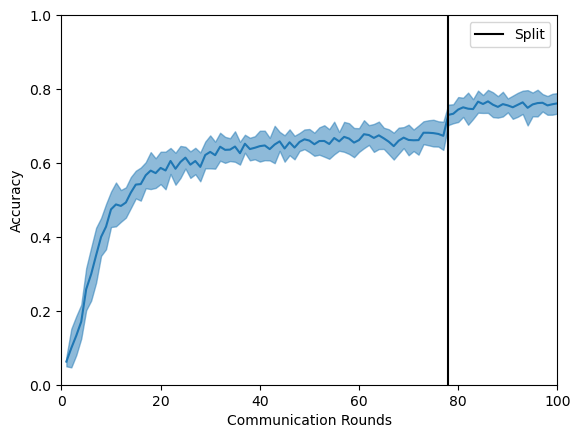

In [22]:
#CFL
server=deepcopy(g_server)
clients=deepcopy(g_clients)
COMMUNICATION_ROUNDS = 100   #通信轮数
EPS_1 = 0.4 #判断全局FL趋于稳定的条件
EPS_2 = 1.6 #判断客户本地模型不适用的条件
res_41=[]
res_42=[]
cfl_stats = ExperimentLogger() #创建实验日志
c_flag=False
c_flag_count=2

cluster_indices = [np.arange(len(clients)).astype("int")] #生成一个从0到99的整数数组，表示客户端的索引
# print(cluster_indices)
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#根据cluster_indices中更新的索引分类进行类别的划分，并进行重新编号？


for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次

    if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
        for client in clients:
            client.synchronize_with_server(server) #将server模型参数下发到client

    participating_clients = server.select_clients(clients, frac=1.0)#选择参与训练的clients的比例，frac控制比例大小

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        #计算参与训练的client权重更新，train_stats保存的是running_loss / samples
        client.reset() #将client的权重参数重置，将旧的值复制到目标位置？？？

    similarities = server.compute_pairwise_similarities(clients)#计算所有的两两设备之间的余弦相似度矩阵

    cluster_indices_new = []#创建一个新的分类列表
    for idc in cluster_indices:
        #print(idc)
        #print(cluster_indices)
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])#计算最大更新范数
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])#计算平均更新范数

        if (mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>0) :#进行划分的判断条件
            server.cache_model(idc, clients[idc[0]].W, acc_clients)#缓存索引、权重值和准确率
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) #获取聚类1 和2
            cluster_indices_new += [c1, c2] #获取第一聚类是第二聚类并放入原来的数据中
            cfl_stats.log({"split" : c_round}) #记录数据 制作图?
            results = np.zeros([N_CLIENTS, len(server.model_cache)]) 
            for i, (idcs, W, accs) in enumerate(server.model_cache):
                 results[idcs, i] = np.array(accs)
            frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) for i in range(results.shape[1]-1)],index = ["Client {}".format(i) for i in range(results.shape[0])])
            models_acc = frame.max(axis=1)


        else:
            cluster_indices_new += [idc]#如果没有到分割状态，保持原样


    cluster_indices = cluster_indices_new #集合更新
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组

    server.aggregate_clusterwise(client_clusters) #获取每组数据的平均梯度和权重

    acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list

    if c_flag==False:
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})
    else:
        max_values = [max(val1, val2) for val1, val2 in zip(models_acc, acc_clients)]
        cfl_stats.log({"acc_clients" : max_values, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})

    res_41,res_42=display_train_stats(res_41,res_42, cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS) #helper类里有画图的类意思就是把数据传进去画图

for idc in cluster_indices:    #缓存所有模型的梯度
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

In [23]:
#PACFL

import numpy as np
from torch.utils.data import Subset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),  # 调整图像大小
    transforms.ToTensor()  # 将图像转换为Tensor
])

# 使用ImageFolder加载数据
D1 = datasets.ImageFolder(root="EMNIST/by_class/", transform=transform)

# 创建一个空列表来存储结果
selected_elements_lists = []

for index_list in client_idcs[:10]:
    selected_elements = [D1[idx][0] for idx in index_list if idx < len(D1)]
    # 将结果列表添加到总列表中
    selected_elements_lists.append(selected_elements)

def concatenate_images(image_lists):
    """Concatenate all tensors in a list along the row dimension after ensuring they all have the same dimensions."""
    min_rows = min(len(images) for images in image_lists)  # Find the minimum count of images in any list
    concatenated_images = [torch.cat(images[:min_rows], dim=0) for images in image_lists]  # Only concatenate up to the minimum count
    return concatenated_images

import numpy as np
from scipy.linalg import svd
from itertools import combinations

def compute_mmd(u_i_k, u_j_k):
    # A placeholder for the MMD computation between two matrices
    # Using a simple difference of means as a placeholder
    return np.abs(u_i_k.mean() - u_j_k.mean())

def calculate_similarity_matrix(u_matrices, k):
    """Calculate the similarity matrix for the first k columns of U matrices."""
    num_matrices = len(u_matrices)
    similarity_matrix = np.zeros((num_matrices, num_matrices))

    for i, j in combinations(range(num_matrices), 2):
        u_i_k = u_matrices[i][:, :k]  # First k columns of U matrix for i-th matrix
        u_j_k = u_matrices[j][:, :k]  # First k columns of U matrix for j-th matrix
        mmd_value = compute_mmd(u_i_k, u_j_k)
        similarity_matrix[i, j] = similarity_matrix[j, i] = mmd_value

    return similarity_matrix

# Assuming image_matrices is a list of 10 matrices, each being a numpy 2D array of the same shape
image_matrices = concatenate_images(selected_elements_lists)
image_matrices = [np.array(matrix).reshape(matrix.shape[0], -1) for matrix in image_matrices]  # Dummy data for illustration
# print(type(image_matrices[0]))
# print(image_matrices[0].shape)

# image_matrices = [np.random.rand(100, 100) for _ in range(10)]

# print(type(image_matrices[0]))
# print(image_matrices[0].shape)

# print(image_matrices[0])
# Perform SVD for each matrix and extract the U matrix
u_matrices = [svd(matrix, full_matrices=False)[0] for matrix in image_matrices]

# Define the number of columns k you want to consider
k = 1  # For example, consider the first 5 columns

# Calculate the similarity matrix for the first k columns of the U matrices
similarity_matrix_svd = calculate_similarity_matrix(u_matrices, k)

print("Similarity Matrix for the first k columns of U matrices:")
print(np.array(similarity_matrix_svd))

from itertools import combinations

# 输入相似度矩阵，这里是一个10x10的二维数组
similarity_matrix = similarity_matrix_svd

# 计算两个用户组内部的平均相似度
def calculate_internal_similarity(group):
    total_similarity = 0
    count = 0
    for user1, user2 in combinations(group, 2):
        total_similarity += similarity_matrix[user1][user2]
        count += 1
    return total_similarity / count if count > 0 else 0

# 计算两个用户组的平均相似度
def calculate_average_similarity(group1, group2):
    avg_similarity_group1 = calculate_internal_similarity(group1)
    avg_similarity_group2 = calculate_internal_similarity(group2)
    return (avg_similarity_group1 + avg_similarity_group2) / 2

# 所有用户的编号
users = list(range(len(similarity_matrix)))

# 生成所有可能的分组组合
all_group_combinations = []
for i in range(1, len(users) // 2 + 1):
    group_combinations = combinations(users, i)
    all_group_combinations.extend(group_combinations)

# 计算每个组合的平均相似度，并排序
average_similarities = []
for group_combination in all_group_combinations:
    group1 = list(group_combination)
    group2 = list(set(users) - set(group_combination))
    avg_similarity = calculate_average_similarity(group1, group2)
    average_similarities.append((avg_similarity, group1, group2))

average_similarities.sort(reverse=True)

# 输出最大的10个平均相似度以及对应的分组情况
print("Top 10 Similarity Scores:")
PACFL_best=[]
for i, (similarity, group1, group2) in enumerate(average_similarities[:5]):
    print(f"{i+1}. Similarity: {similarity:.10f}, Group 1: {group1}, Group 2: {group2}")
    PACFL_best.append([group1,group2])

Similarity Matrix for the first k columns of U matrices:
[[0.00000000e+00 1.97440386e-07 3.50177288e-07 2.49594450e-07
  1.11758709e-07 1.75088644e-07 4.80562449e-07 5.21540642e-08
  4.39584255e-07 5.14090061e-07]
 [1.97440386e-07 0.00000000e+00 5.47617674e-07 4.47034836e-07
  8.56816769e-08 2.23517418e-08 2.83122063e-07 1.45286322e-07
  6.37024641e-07 7.11530447e-07]
 [3.50177288e-07 5.47617674e-07 0.00000000e+00 1.00582838e-07
  4.61935997e-07 5.25265932e-07 8.30739737e-07 4.02331352e-07
  8.94069672e-08 1.63912773e-07]
 [2.49594450e-07 4.47034836e-07 1.00582838e-07 0.00000000e+00
  3.61353159e-07 4.24683094e-07 7.30156898e-07 3.01748514e-07
  1.89989805e-07 2.64495611e-07]
 [1.11758709e-07 8.56816769e-08 4.61935997e-07 3.61353159e-07
  0.00000000e+00 6.33299351e-08 3.68803740e-07 5.96046448e-08
  5.51342964e-07 6.25848770e-07]
 [1.75088644e-07 2.23517418e-08 5.25265932e-07 4.24683094e-07
  6.33299351e-08 0.00000000e+00 3.05473804e-07 1.22934580e-07
  6.14672899e-07 6.89178705e-07]
 

[0.05501334 0.09969131 0.16608506 0.21906852 0.26436761 0.31581575
 0.35292286 0.42008211 0.43454496 0.46208776 0.49929839 0.5113921
 0.53100445 0.53530713 0.56624939 0.55357096 0.54254175 0.58452285
 0.57907694 0.58877588 0.61014243 0.61174612 0.62321738 0.61229831
 0.60584062 0.63774259 0.63653563 0.63704493 0.63866795 0.632416
 0.64479745 0.62537093 0.64418293 0.65397354 0.64835408 0.65286942
 0.66291595 0.66484341 0.65851221 0.65165124 0.65648249 0.66251476
 0.65941271 0.66717119 0.67398586 0.67092081 0.66241354 0.67423903
 0.66902691 0.67327007 0.67392959 0.67023531 0.67050817 0.68203579
 0.65542693 0.65754977 0.67657633 0.65702679 0.66128896 0.66500006
 0.65764272 0.67470995 0.66267386 0.68866335 0.68551075 0.6655718
 0.67496073 0.68146965 0.67330047 0.68451268 0.6748076  0.67787627
 0.67944325 0.67786133 0.67823745 0.669382   0.67974118 0.67599785
 0.68676537 0.68272251 0.67520439 0.67348852 0.6635892  0.67889451
 0.68355158 0.68347386 0.6740731  0.66085831 0.67911606 0.68125569

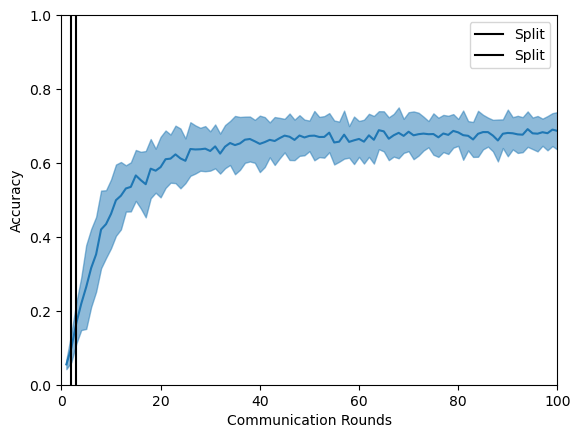

In [24]:
#PACFL
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def run_federated_learning(server, clients,partitions):
    print(partitions)
    res_51=[]
    res_52=[]
    plt1=plt.figure(figsize=(12,4))
    plt.subplot(1,1,1)

    COMMUNICATION_ROUNDS = 100   #通信轮数
    EPS_1 = 0.4 #判断全局FL趋于稳定的条件
    EPS_2 = 1.6 #判断客户本地模型不适用的条件
    cfl_stats = ExperimentLogger() #创建实验日志
    cluster_indices_new = []
    c_flag=False
    c_flag_count=2
    models_acc=[]


    cluster_indices = [np.arange(len(clients)).astype("int")] #生成一个从0到99的整数数组，表示客户端的索引
# print(cluster_indices)
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#根据cluster_indices中更新的索引分类进行类别的划分，并进行重新编号？

    def remove_empty_lists(input_list):
    # 使用列表推导式过滤空列表
        result_list = [sublist for sublist in input_list if sublist]
        return result_list

    for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次
        if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
            for client in clients:
                client.synchronize_with_server(server) #将server模型参数下发到client

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=1)
            client.reset()

        similarities = server.compute_pairwise_similarities(clients)

        if  (c_round%1000==0 and  c_round>=30) or c_round==2 or c_round==3:
            if 0==1:
                print("eee")
            else:
                for idc in cluster_indices:
                    server.cache_model(idc, clients[idc[0]].W, acc_clients)
                if c_round==2 :
                    clusters_res=[[0,1,2,3,4,5,6,7,8,9]]
                else:
                    clusters_res=partitions #70

            cluster_indices_new=clusters_res
            cfl_stats.log({"split" : c_round})
            results = np.zeros([N_CLIENTS, len(server.model_cache)]) 
            for i, (idcs, W, accs) in enumerate(server.model_cache):
                results[idcs, i] = np.array(accs)
            frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) for i in range(results.shape[1]-1)],index = ["Client {}".format(i) for i in range(results.shape[0])])
            models_acc = frame.max(axis=1)
            c_flag_count=c_flag_count-1
            if c_flag_count==0:
                c_flag=True
        
        if cluster_indices_new!=[]:
            cluster_indices = cluster_indices_new #集合更新
            cluster_indices = remove_empty_lists(cluster_indices)

        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组

        server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重

        acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list

        print("acc",acc_clients)

        if c_flag==False:
            cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})
        else:
            max_values = [max(val1, val2) for val1, val2 in zip(models_acc, acc_clients)]
            cfl_stats.log({"acc_clients" : max_values, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})

        res_51,res_52=display_train_stats(res_51,res_52, cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS) #helper类里有画图的类意思就是把数据传进去画图
    
    return max_values,res_51,res_52

for i in range(1):
    print(i)
    print(PACFL_best)
    server=deepcopy(g_server)
    clients=deepcopy(g_clients)
    tmp_max_values,res_51,res_52=run_federated_learning(server,clients,PACFL_best[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.05793406 0.11284549 0.15836608 0.19376723 0.25991072 0.33881667
 0.35140907 0.39441769 0.42902464 0.47566049 0.47970469 0.49229568
 0.48735592 0.51860154 0.53477807 0.52714479 0.57190871 0.53358574
 0.56189586 0.65228982 0.65590743 0.66102388 0.66345803 0.66833903
 0.66887095 0.66936356 0.67088069 0.67285114 0.67538921 0.67997479
 0.68126978 0.68449203 0.68593029 0.68593029 0.68645113 0.69030118
 0.69030118 0.69030118 0.69134284 0.69180796 0.69512957 0.69559468
 0.6994218  0.6994218  0.70089963 0.70331745 0.70331745 0.70331745
 0.70629364 0.70629364 0.70773594 0.71188102 0.71340386 0.71340386
 0.71340386 0.71500814 0.71741621 0.71741621 0.71741621 0.71741621
 0.71741621 0.71741621 0.71794812 0.71794812 0.71794812 0.71794812
 0.71848288 0.71848288 0.71848288 0.71848288 0.71848288 0.72084966
 0.72084966 0.72084966 0.72084966 0.72084966 0.72084966 0.72084966
 0.7228201  0.72436725 0.72638037 0.72638037 0.72638037 0.72638037
 0.72793477 0.72793477 0.72948917 0.73156171 0.73156171 0.7321

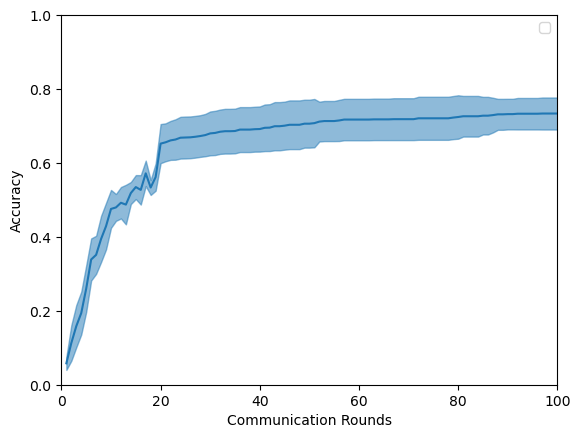

In [25]:
#根据s的状态进行聚类，每次都hc聚类
#s_hc_ifca
from scipy.cluster.hierarchy import linkage, fcluster

def h_c(juling_num, similarities):
    # 使用linkage函数进行层次聚类
    linkage_matrix = linkage(similarities, method='complete')
    
    # 使用fcluster函数根据指定的聚类数目进行聚类
    labels = fcluster(linkage_matrix, juling_num, criterion='maxclust')
    
    # 将聚类结果整理成字典的形式
    clusters = {}
    for i, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(i)
    
    return list(clusters.values())

server=deepcopy(g_server)
clients=deepcopy(g_clients)
import numpy as np
import pandas as pd
res_61=[]
res_62=[]
#正要修改的
plt1=plt.figure(figsize=(12,4))
plt.subplot(1,1,1)

COMMUNICATION_ROUNDS = 100   #通信轮数
juling_num=1
EPS_1 = 0.4 #判断全局FL趋于稳定的条件
EPS_2 = 1.6 #判断客户本地模型不适用的条件
cfl_stats = ExperimentLogger() #创建实验日志
cluster_indices_new = []
c_flag=False
c_flag_count=2
models_acc=[]



cluster_indices = [np.arange(len(clients)).astype("int")] #生成一个从0到99的整数数组，表示客户端的索引
# print(cluster_indices)
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#根据cluster_indices中更新的索引分类进行类别的划分，并进行重新编号？

def remove_empty_lists(input_list):
    # 使用列表推导式过滤空列表
    result_list = [sublist for sublist in input_list if sublist]
    return result_list

for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次
  if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
      for client in clients:
          client.synchronize_with_server(server) #将server模型参数下发到client

  participating_clients = server.select_clients(clients, frac=1.0)

  for client in participating_clients:
    train_stats = client.compute_weight_update(epochs=1)
    client.reset()
  
  max_norm = server.compute_max_update_norm([clients[i] for i in idc])#计算最大更新范数
  mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])#计算平均更新范数
  similarities = server.compute_pairwise_similarities(clients)
  
  #if (c_round>=0 and c_round%5==0) :
  # if (mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>0) or c_round==2 or c_round==3:
  if c_round==20 or (c_round%1==0 and  c_round>=20) or c_round==2 or c_round==3:
    for idc in cluster_indices:
        server.cache_model(idc, clients[idc[0]].W, acc_clients)
    juling_num=juling_num+1
    if c_round==2 or c_round==3:
      juling_num=juling_num-1
    else:
      juling_num=juling_num+1
      
    print("****",juling_num)
    # clusters_res = yichuanal(N_CLIENTS,juling_num,similarities)
    clusters_res=h_c(juling_num, similarities)
    # cfl_stats.log({"split" : c_round})
    results = np.zeros([N_CLIENTS,len(server.model_cache)])
    for i,(idcs,W, accs) in enumerate(server.model_cache):
       results[idcs,i]=np.array(accs)
    frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) for i in range(results.shape[1]-1)],index = ["Client {}".format(i) for i in range(results.shape[0])])
    models_acc = frame.max(axis=1)
    print(clusters_res)
    cluster_indices_new=clusters_res
    c_flag_count=c_flag_count-1
    if c_flag_count==0:
      c_flag=True
      

  if cluster_indices_new!=[]:
     cluster_indices = cluster_indices_new #集合更新
     cluster_indices = remove_empty_lists(cluster_indices)

  client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组

  server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重

  acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list
  if c_flag==False:
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})
  else:
    max_values = [max(val1, val2) for val1, val2 in zip(models_acc, acc_clients)]
    cfl_stats.log({"acc_clients" : max_values, "mean_norm" : 0, "max_norm" : 0, "rounds" : c_round,  "clusters" : []})

  print("*******",cfl_stats.acc_clients)
  print(len(cfl_stats.acc_clients))
  print(np.mean(cfl_stats.acc_clients, axis=1))
  res_61,res_62=display_train_stats(res_61,res_62, cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS) #helper类里有画图的类意思就是把数据传进去画图

for idc in cluster_indices:    #缓存所有模型的梯度
   server.cache_model(idc, clients[idc[0]].W, acc_clients)

In [28]:
import numpy as np

def write_data_to_txt(*arrays, filename='data_set.txt'):
    # 准备文件内容，每个数组转换为逗号分隔的字符串，并添加到列表中
    lines = []
    for idx, arr in enumerate(arrays):
        arr_str = ', '.join(map(str, arr))
        lines.append(f"arr_{idx+1}=[{arr_str}]\n")
    
    # 构造最终的文件内容
    file_content = ''.join(lines)

    # 将内容写入文件
    with open(filename, 'w') as file:
        file.write(file_content)

    print(f"数据已成功写入到 {filename} 文件中。")



# 调用函数，将所有数组作为参数传递
write_data_to_txt(res_21,res_22,res_31,res_32,res_41,res_42,res_51,res_52,res_61, res_62, filename="data_set.txt")

数据已成功写入到 data_set.txt 文件中。
